#  Data learning

## learning is parameter estimation
首先使用了校准仪器的案例来引入一个较为简单的学习案例 calibrating instruments  

文中提到，desired outputs就是ground truth

In [1]:
import torch
import os
import pandas as pd
import numpy as np

In [2]:
# temperature data
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]    # Clesius
t_u = [35.7,55.9, 58.2, 81.9, 56.3, 48.9,33.9,21.8,48.4, 60.4, 68.4]    # unknown units
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

首先使用线性模型进行尝试  
$t_c = w * t_u + b$

## 损失函数
损失函数需要确定修复错误的优先级  
参数更新 首先要对高权重样本的输出进行调整，而不是对损失较小的其他样本  
monotonically - 单调地  
convex - 凸的 function  
相对来说深度神经网络不会出现凸损失？？

In [3]:
# linear model
def model(t_u, w, b):
    return w * t_u +ｂ

这里的loss函数是差的频繁，然后求了平均值

In [4]:
# loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [5]:
w = torch.ones(1)
b = torch.zeros(1)

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [6]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

## 梯度下降
knobs - 旋钮  
文中将调节步幅的参数，step视为旋钮  
或者把调节w 和 b的操作视为转动旋钮

In [7]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w+delta, b), t_c) - 
     loss_fn(model(t_u, w-delta, b), t_c)) / (2.0 * delta)

在上面的代码中，对w做一点微小调整，观察对loss的影响，如果结果是负的，那么需要增大w，如果是正的，那么需要减小w

In [8]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

In [9]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b+delta), t_c) - 
     loss_fn(model(t_u, w, b-delta), t_c)) / (2.0*delta)

b = b - learning_rate * loss_rate_of_change_b

下面的部分这是这还能对上面的loss、w、b三个函数求导数  
就是数学上的导数，然后直接计算一遍就好了

In [10]:
def dloss_fn(t_p, t_c):
    dsp_diffs = 2 * (t_p - t_c)
    return dsp_diffs

In [12]:
def dmodel_dw(t_u, w, b):
    return t_u

In [13]:
def dmodel_db(t_u, w, b):
    return 1.0

In [22]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_p, t_c) * dmodel_dw(t_u, w, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])

训练周期  
tentative - 精明，试验

In [23]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        params = params - learning_rate * grad
        
        print('Epoch %d, loss %f' % (epoch, float(loss)))
        print('\t Params:', params)
        print('\t Grad:  ', grad)
        
    return params

In [25]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, loss 1763.884644
	 Params: tensor([ 0.5483, -0.0083])
	 Grad:   tensor([4517.2964,   82.6000])
Epoch 2, loss 323.090546
	 Params: tensor([ 0.3623, -0.0118])
	 Grad:   tensor([1859.5493,   35.7843])
Epoch 3, loss 78.929634
	 Params: tensor([ 0.2858, -0.0135])
	 Grad:   tensor([765.4666,  16.5122])
Epoch 4, loss 37.552845
	 Params: tensor([ 0.2543, -0.0143])
	 Grad:   tensor([315.0790,   8.5787])
Epoch 5, loss 30.540285
	 Params: tensor([ 0.2413, -0.0149])
	 Grad:   tensor([129.6733,   5.3127])
Epoch 6, loss 29.351152
	 Params: tensor([ 0.2360, -0.0153])
	 Grad:   tensor([53.3496,  3.9682])
Epoch 7, loss 29.148882
	 Params: tensor([ 0.2338, -0.0156])
	 Grad:   tensor([21.9304,  3.4148])
Epoch 8, loss 29.113848
	 Params: tensor([ 0.2329, -0.0159])
	 Grad:   tensor([8.9964, 3.1869])
Epoch 9, loss 29.107145
	 Params: tensor([ 0.2325, -0.0162])
	 Grad:   tensor([3.6721, 3.0930])
Epoch 10, loss 29.105242
	 Params: tensor([ 0.2324, -0.0166])
	 Grad:   tensor([1.4803, 3.0544])
Epoch 11

tensor([ 0.2327, -0.0438])

上面的训练中，loss反而是越来越大了  
原因自然是参数更新的步长有点大了，说明优化方法还不够好  
而且，你会看到刚开始的时候，w 和 b 根本不在一个数量级，如果能为不同参数独立设置学习率可能会更好，但是也会更麻烦

### normalization
还有一种方法：那就是更改inputs，让这些梯度值不会差异这么大：也就是说将输入值归一化到 -1和1 之间

In [26]:
t_un = 0.1 * t_u

In [32]:
params = training_loop(
    n_epochs = 1000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

Epoch 1, loss 80.364342
	 Params: tensor([1.7761, 0.1064])
	 Grad:   tensor([-77.6140, -10.6400])
Epoch 2, loss 37.574917
	 Params: tensor([2.0848, 0.1303])
	 Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, loss 30.871077
	 Params: tensor([2.2094, 0.1217])
	 Grad:   tensor([-12.4631,   0.8587])
Epoch 4, loss 29.756193
	 Params: tensor([2.2616, 0.1004])
	 Grad:   tensor([-5.2218,  2.1327])
Epoch 5, loss 29.507149
	 Params: tensor([2.2853, 0.0740])
	 Grad:   tensor([-2.3715,  2.6310])
Epoch 6, loss 29.392458
	 Params: tensor([2.2978, 0.0458])
	 Grad:   tensor([-1.2492,  2.8241])
Epoch 7, loss 29.298828
	 Params: tensor([2.3059, 0.0168])
	 Grad:   tensor([-0.8071,  2.8970])
Epoch 8, loss 29.208717
	 Params: tensor([ 2.3122, -0.0124])
	 Grad:   tensor([-0.6325,  2.9227])
Epoch 9, loss 29.119417
	 Params: tensor([ 2.3178, -0.0417])
	 Grad:   tensor([-0.5633,  2.9298])
Epoch 10, loss 29.030487
	 Params: tensor([ 2.3232, -0.0710])
	 Grad:   tensor([-0.5355,  2.9295])
Epoch 11, loss 28.941875
	 

	 Grad:   tensor([-0.4007,  2.2686])
Epoch 162, loss 18.495083
	 Params: tensor([ 3.0166, -3.9958])
	 Grad:   tensor([-0.4001,  2.2647])
Epoch 163, loss 18.442238
	 Params: tensor([ 3.0206, -4.0184])
	 Grad:   tensor([-0.3994,  2.2609])
Epoch 164, loss 18.389570
	 Params: tensor([ 3.0246, -4.0409])
	 Grad:   tensor([-0.3987,  2.2570])
Epoch 165, loss 18.337080
	 Params: tensor([ 3.0286, -4.0635])
	 Grad:   tensor([-0.3980,  2.2532])
Epoch 166, loss 18.284777
	 Params: tensor([ 3.0326, -4.0860])
	 Grad:   tensor([-0.3974,  2.2494])
Epoch 167, loss 18.232643
	 Params: tensor([ 3.0365, -4.1084])
	 Grad:   tensor([-0.3967,  2.2456])
Epoch 168, loss 18.180687
	 Params: tensor([ 3.0405, -4.1308])
	 Grad:   tensor([-0.3960,  2.2417])
Epoch 169, loss 18.128904
	 Params: tensor([ 3.0445, -4.1532])
	 Grad:   tensor([-0.3953,  2.2379])
Epoch 170, loss 18.077299
	 Params: tensor([ 3.0484, -4.1756])
	 Grad:   tensor([-0.3947,  2.2341])
Epoch 171, loss 18.025879
	 Params: tensor([ 3.0523, -4.1979])


	 Grad:   tensor([-0.3069,  1.7371])
Epoch 319, loss 12.055373
	 Params: tensor([ 3.5674, -7.1137])
	 Grad:   tensor([-0.3063,  1.7342])
Epoch 320, loss 12.024384
	 Params: tensor([ 3.5705, -7.1310])
	 Grad:   tensor([-0.3058,  1.7312])
Epoch 321, loss 11.993508
	 Params: tensor([ 3.5736, -7.1483])
	 Grad:   tensor([-0.3053,  1.7283])
Epoch 322, loss 11.962732
	 Params: tensor([ 3.5766, -7.1656])
	 Grad:   tensor([-0.3048,  1.7253])
Epoch 323, loss 11.932056
	 Params: tensor([ 3.5796, -7.1828])
	 Grad:   tensor([-0.3043,  1.7224])
Epoch 324, loss 11.901492
	 Params: tensor([ 3.5827, -7.2000])
	 Grad:   tensor([-0.3037,  1.7195])
Epoch 325, loss 11.871029
	 Params: tensor([ 3.5857, -7.2172])
	 Grad:   tensor([-0.3032,  1.7166])
Epoch 326, loss 11.840671
	 Params: tensor([ 3.5887, -7.2343])
	 Grad:   tensor([-0.3027,  1.7136])
Epoch 327, loss 11.810413
	 Params: tensor([ 3.5918, -7.2514])
	 Grad:   tensor([-0.3022,  1.7107])
Epoch 328, loss 11.780257
	 Params: tensor([ 3.5948, -7.2685])


	 Params: tensor([ 4.0147, -9.6458])
	 Grad:   tensor([-0.2302,  1.3033])
Epoch 488, loss 8.065548
	 Params: tensor([ 4.0170, -9.6589])
	 Grad:   tensor([-0.2298,  1.3011])
Epoch 489, loss 8.048104
	 Params: tensor([ 4.0193, -9.6718])
	 Grad:   tensor([-0.2295,  1.2989])
Epoch 490, loss 8.030723
	 Params: tensor([ 4.0216, -9.6848])
	 Grad:   tensor([-0.2291,  1.2967])
Epoch 491, loss 8.013400
	 Params: tensor([ 4.0239, -9.6978])
	 Grad:   tensor([-0.2287,  1.2945])
Epoch 492, loss 7.996135
	 Params: tensor([ 4.0262, -9.7107])
	 Grad:   tensor([-0.2283,  1.2923])
Epoch 493, loss 7.978929
	 Params: tensor([ 4.0285, -9.7236])
	 Grad:   tensor([-0.2279,  1.2901])
Epoch 494, loss 7.961784
	 Params: tensor([ 4.0308, -9.7365])
	 Grad:   tensor([-0.2275,  1.2879])
Epoch 495, loss 7.944690
	 Params: tensor([ 4.0330, -9.7493])
	 Grad:   tensor([-0.2271,  1.2857])
Epoch 496, loss 7.927662
	 Params: tensor([ 4.0353, -9.7621])
	 Grad:   tensor([-0.2267,  1.2835])
Epoch 497, loss 7.910690
	 Params: 

	 Params: tensor([  4.3561, -11.5781])
	 Grad:   tensor([-0.1722,  0.9745])
Epoch 659, loss 5.800117
	 Params: tensor([  4.3578, -11.5878])
	 Grad:   tensor([-0.1719,  0.9728])
Epoch 660, loss 5.790367
	 Params: tensor([  4.3595, -11.5975])
	 Grad:   tensor([-0.1716,  0.9712])
Epoch 661, loss 5.780647
	 Params: tensor([  4.3612, -11.6072])
	 Grad:   tensor([-0.1713,  0.9695])
Epoch 662, loss 5.770962
	 Params: tensor([  4.3629, -11.6169])
	 Grad:   tensor([-0.1710,  0.9679])
Epoch 663, loss 5.761312
	 Params: tensor([  4.3646, -11.6266])
	 Grad:   tensor([-0.1707,  0.9662])
Epoch 664, loss 5.751693
	 Params: tensor([  4.3664, -11.6362])
	 Grad:   tensor([-0.1704,  0.9646])
Epoch 665, loss 5.742105
	 Params: tensor([  4.3681, -11.6458])
	 Grad:   tensor([-0.1701,  0.9630])
Epoch 666, loss 5.732550
	 Params: tensor([  4.3697, -11.6555])
	 Grad:   tensor([-0.1698,  0.9613])
Epoch 667, loss 5.723031
	 Params: tensor([  4.3714, -11.6651])
	 Grad:   tensor([-0.1695,  0.9597])
Epoch 668, loss

	 Grad:   tensor([-0.1336,  0.7564])
Epoch 808, loss 4.658320
	 Params: tensor([  4.5838, -12.8672])
	 Grad:   tensor([-0.1334,  0.7551])
Epoch 809, loss 4.652445
	 Params: tensor([  4.5851, -12.8748])
	 Grad:   tensor([-0.1332,  0.7538])
Epoch 810, loss 4.646592
	 Params: tensor([  4.5865, -12.8823])
	 Grad:   tensor([-0.1330,  0.7526])
Epoch 811, loss 4.640753
	 Params: tensor([  4.5878, -12.8898])
	 Grad:   tensor([-0.1327,  0.7513])
Epoch 812, loss 4.634938
	 Params: tensor([  4.5891, -12.8973])
	 Grad:   tensor([-0.1325,  0.7500])
Epoch 813, loss 4.629142
	 Params: tensor([  4.5904, -12.9048])
	 Grad:   tensor([-0.1323,  0.7487])
Epoch 814, loss 4.623368
	 Params: tensor([  4.5918, -12.9123])
	 Grad:   tensor([-0.1320,  0.7475])
Epoch 815, loss 4.617611
	 Params: tensor([  4.5931, -12.9197])
	 Grad:   tensor([-0.1318,  0.7462])
Epoch 816, loss 4.611873
	 Params: tensor([  4.5944, -12.9272])
	 Grad:   tensor([-0.1316,  0.7449])
Epoch 817, loss 4.606156
	 Params: tensor([  4.5957, -

Epoch 955, loss 3.977496
	 Params: tensor([  4.7572, -13.8486])
	 Grad:   tensor([-0.1039,  0.5881])
Epoch 956, loss 3.973933
	 Params: tensor([  4.7582, -13.8544])
	 Grad:   tensor([-0.1037,  0.5871])
Epoch 957, loss 3.970380
	 Params: tensor([  4.7592, -13.8603])
	 Grad:   tensor([-0.1035,  0.5861])
Epoch 958, loss 3.966843
	 Params: tensor([  4.7603, -13.8661])
	 Grad:   tensor([-0.1034,  0.5851])
Epoch 959, loss 3.963314
	 Params: tensor([  4.7613, -13.8720])
	 Grad:   tensor([-0.1032,  0.5841])
Epoch 960, loss 3.959798
	 Params: tensor([  4.7623, -13.8778])
	 Grad:   tensor([-0.1030,  0.5832])
Epoch 961, loss 3.956294
	 Params: tensor([  4.7634, -13.8836])
	 Grad:   tensor([-0.1029,  0.5822])
Epoch 962, loss 3.952804
	 Params: tensor([  4.7644, -13.8895])
	 Grad:   tensor([-0.1027,  0.5812])
Epoch 963, loss 3.949322
	 Params: tensor([  4.7654, -13.8953])
	 Grad:   tensor([-0.1025,  0.5802])
Epoch 964, loss 3.945856
	 Params: tensor([  4.7664, -13.9010])
	 Grad:   tensor([-0.1023, 

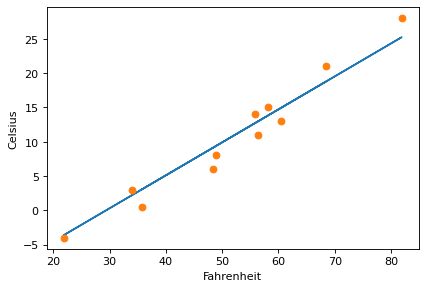

In [33]:
from matplotlib import pyplot as plt

t_p = model(t_un, *params)
fig = plt.figure(dpi = 80)
plt.xlabel("Fahrenheit")
plt.ylabel('Celsius')

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')